## [Data Science] Image Processing : Exploratory & Modeling
In this poject we will work on a set of image of letters in plenty of differents fronts.
The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.


You need to go step by step through this notebook, and fill the code in the //TODO. 
Please make sure to explain clearly all your choices. 

In [1]:

# These are all the modules that could be use for this project. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
# renaming the pickle function because there is already a pickle fun and python seems to confond them
from six.moves import cPickle as pkl
%matplotlib inline
np.random.seed(133)
print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')


Using Python  = 3.8.5
Tensorflow    = 2.5.0


## Step 1 Download data set

In [ ]:
In order to save you time we provide this function

In [2]:

url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress(count, blockSize, totalSize):
  """
  Simple hook to report the progress of a download. 
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def gz_download(filename, expected_bytes, force=False):
  """
  Download a file if not present, and make sure it's the right size.
  """
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = gz_download('notMNIST_large.tar.gz', 247336696)
test_filename = gz_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [3]:
def tar_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

    my_tar = tarfile.open(filename)
    my_tar.extractall(os.path.join(os.getcwd(),root)) # specify which folder to extract to
    my_tar.close()
    data_folders_name = os.listdir(os.path.join(os.getcwd(),root,root))
    data_folders = [os.path.join(os.getcwd(),root,root,fldr) for fldr in data_folders_name]


    print(data_folders)
    return data_folders
  
train_folders = tar_extract(train_filename)
test_folders = tar_extract(test_filename)

['C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\A', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\B', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\C', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\D', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\E', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\F', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\G', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\H', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\developers\\DataScience\\.\\notMNIST_large\\.\\notMNIST_large\\I', 'C:\\Users\\geoff\\Desktop\\fulll_aix\\develo

## Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. 

A selection of random images and their label


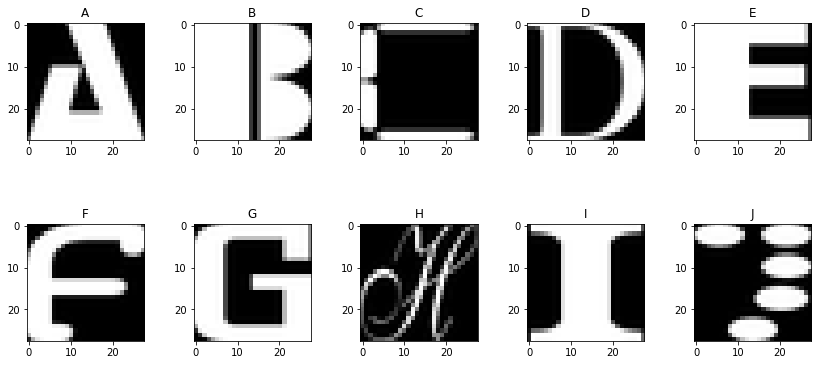

In [4]:
# Let's sample randomly one image from each folder and see if the folder name correspond to the image

def get_img_sample(folder):
    """ Get an image from each class and its label"""
    samples = []
    # Gonna go through each folder to extrat the folder name and import a random image 
    for i in range(0,len(folder)):
        current_folder = folder[i]
        folder_name = current_folder[-1]
        # Generating a random index 
        random_value = np.random.randint(low=0, high=len(os.listdir(current_folder)), size=1,)[0]
        # Sampeling an image path with the random index
        img_path = os.path.join(current_folder,os.listdir(current_folder)[random_value])
        # Appending the (folder name , random image array) to a list
        samples.append((folder_name,plt.imread(img_path)))
        
    return samples

def plt_sample(sample):
    """ Plot a sample of images """
    fig=plt.figure(figsize=(12,6))
    rows = 2
    columns = 5
    for idx,val in enumerate(sample):

        fig.add_subplot(rows, columns, idx+1)
        plt.imshow(val[1], cmap="gray")
        plt.title(val[0])

    fig.tight_layout(pad=3.0)
    plt.show()

samples = get_img_sample(train_folders)
print("A selection of random images and their label")
plt_sample(samples)

In [5]:
# As we can see, each random image seems to correspond to its label/folder name.Everything seems to be in order.


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. We could merge into a single dataset of manageable size if needed.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.


In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letters(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    except ValueError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letters(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pkl.dump(dataset, f, pkl.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = pickle(train_folders, 45000)
test_datasets = pickle(test_folders, 1800)

Pickling C:\Users\geoff\Desktop\fulll_aix\developers\DataScience\.\notMNIST_large\.\notMNIST_large\A.pickle.
C:\Users\geoff\Desktop\fulll_aix\developers\DataScience\.\notMNIST_large\.\notMNIST_large\A
Could not read: C:\Users\geoff\Desktop\fulll_aix\developers\DataScience\.\notMNIST_large\.\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
Could not read: C:\Users\geoff\Desktop\fulll_aix\developers\DataScience\.\notMNIST_large\.\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
Could not read: C:\Users\geoff\Desktop\fulll_aix\developers\DataScience\.\notMNIST_large\.\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.443120

## Problem 2
Verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

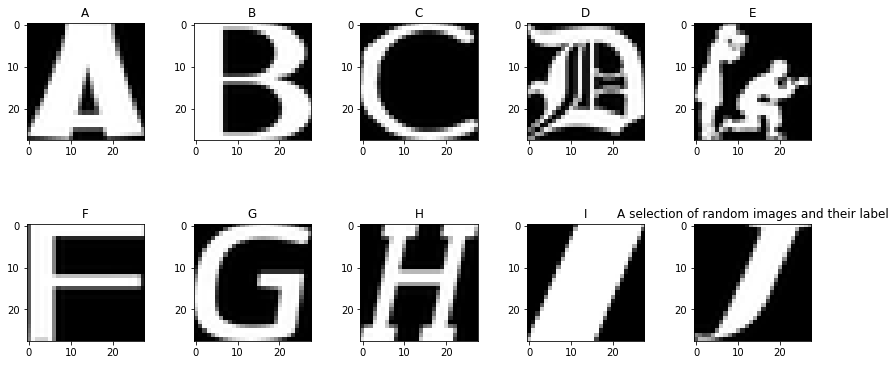

In [7]:
# Let's import some images from the pickle files and make sure that the previous operations did not disturb the nature of the images and the label associated with them.

# Train dataset
samples = []
# Gonna go through each pickle file to extract the label and a random image array
for pkl_path in train_datasets:
    # Loading the pickle file
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f)
    # Generating a random index 
    random_value = np.random.randint(low=0, high=pkl_data.shape[0], size=1,)[0]
    current_label = pkl_path.split(".")[-2][-1]
    # Appending the current label, random image array tuple to a list
    samples.append((current_label,pkl_data[random_value,:,:]))

# Plotting the sampled images
plt_sample(samples)

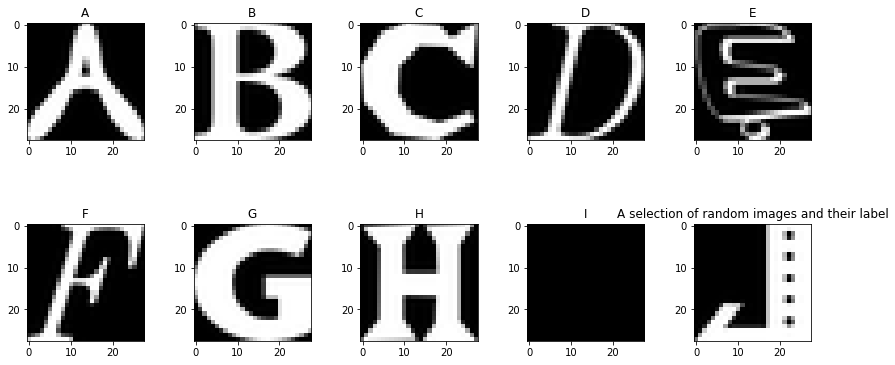

In [8]:
# Test dataset
samples = []
# Gonna go through each pickle file to extract the label and a random image array
for pkl_path in test_datasets:
    # Loading the pickle file
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f) 
    # Generating a random index 
    random_value = np.random.randint(low=0, high=pkl_data.shape[0], size=1,)[0]
    current_label = pkl_path.split(".")[-2][-1]
    # Appending the current label, random image array tuple to a list
    samples.append((current_label,pkl_data[random_value,:,:]))

# Plotting the sampled images   
plt_sample(samples)

In [9]:
# As we can see, for both the dataset, the images are still the one corresponding to their expected label. The previous operations does not seem to have disturbed the nature of the images or the folder the belong to.

## Problem 3
Another check: Verify that the data is balanced across classes. 

In [10]:
# Let's load the different pickle files for test and train and check the number of images per classes
print("For the train dataset")
for pkl_path in train_datasets:
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f) 
    current_label = pkl_path.split(".")[-2][-1]
    print(f" The Number of images for label {current_label} is : {pkl_data.shape[0]}" )

For the train dataset
 The Number of images for label A is : 52909
 The Number of images for label B is : 52911
 The Number of images for label C is : 52912
 The Number of images for label D is : 52911
 The Number of images for label E is : 52912
 The Number of images for label F is : 52912
 The Number of images for label G is : 52912
 The Number of images for label H is : 52912
 The Number of images for label I is : 52912
 The Number of images for label J is : 52911


In [11]:
print("For the test dataset")
for pkl_path in test_datasets:
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f) 
    current_label = pkl_path.split(".")[-2][-1]
    print(f" The Number of images for label {current_label} is : {pkl_data.shape[0]}" )

For the test dataset
 The Number of images for label A is : 1872
 The Number of images for label B is : 1873
 The Number of images for label C is : 1873
 The Number of images for label D is : 1873
 The Number of images for label E is : 1873
 The Number of images for label F is : 1872
 The Number of images for label G is : 1872
 The Number of images for label H is : 1872
 The Number of images for label I is : 1872
 The Number of images for label J is : 1872


In [12]:
# The dataset is clearly balance accross classes for the test dataset and the train dataset. Indeed most classes share the same number of images besides for a few that are missing one.


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
# Here, we are going to select a size for our train, validation and test dataset and every class will a a number of images equal to the dataset size/ number of classes
# For example 
# Sizes
train_size = 200000
valid_size = 10000
test_size = 10000

# A label dictionary to convert the label name to an int
label_dict = {"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6,"H":7,"I":8,"J":9,}
# Calculating the number of images per  class base on the target dataset size
img_per_class_train = train_size//len(label_dict)
img_per_class_val = valid_size//len(label_dict)
total_img_per_class = img_per_class_train+img_per_class_val
img_per_class_test = test_size//len(label_dict)

# For train and val
train_list = []
val_list = []
train_labels = []
valid_labels = []
# Gonna go through each pickle file to sample randomly the requiered number of images and their labels
for pkl_path in train_datasets:
    # Loading the pickle file
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f)
    # Generating index to randomly sample images for the training set and validation set
    random_values = np.random.randint(low=0, high=pkl_data.shape[0], size=total_img_per_class,)
    current_label = pkl_path.split(".")[-2][-1]
    # Extracting the images from this class for the validation and training datasets
    val_train_data = pkl_data[random_values,:,:]
    # Extracting the images from this class for the training set
    train_sample = val_train_data[:img_per_class_train,:,:]
    # Extracting the images from this class for the validation set
    val_sample = val_train_data[-img_per_class_val:,:,:]
    
    train_list.append(train_sample)
    val_list.append(val_sample)
    # Building a list for the sample labels for the training and validation datasets
    train_labels = train_labels + [label_dict[current_label]]*img_per_class_train
    valid_labels = valid_labels + [label_dict[current_label]]*img_per_class_val
    
# Concatenating the different dataset list per class to get a training and valisation array for all the classes
train_dataset = np.concatenate(train_list,axis=0)
valid_dataset = np.concatenate(val_list,axis=0)
# Converting the label lists to arrays
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

# For the test dataset
# Here, we are doing the same thing but for the testset. The only difference is that there is no need to extract 2 datasets
test_list = []
test_labels = []
for pkl_path in test_datasets:
    with open(pkl_path,"rb") as f:
        pkl_data = pkl.load(f) 
    random_values = np.random.randint(low=0, high=pkl_data.shape[0], size=img_per_class_test,)
    current_label = pkl_path.split(".")[-2][-1]
    
    test_data = pkl_data[random_values,:,:]
    
    test_list.append(test_data)
    
    test_labels = test_labels + [label_dict[current_label]]*img_per_class_test

test_dataset = np.concatenate(test_list,axis=0)

test_labels = np.array(test_labels)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.



In [21]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
Convince yourself that the data is still good after shuffling!



In [22]:
# Let's as previously extract label and images arrays randomly and check if the are corresponding.

In [23]:
def check_shuffle_effect(dataset,labels_list,label_dict=label_dict):
    """ Plot the shuffle images to make sure the label is the right one"""
    # Getting a random sample of indexes
    random_values = np.random.randint(low=0, high=dataset.shape[0], size=len(label_dict))
    # Reversing the label_dict to display the label names
    idx2label = {j:i for i,j in label_dict.items()}
    samples = [(idx2label[labels_list[i]],dataset[i,:,:]) for i in random_values]
    # Ploting
    plt_sample(samples)

For the train dataset


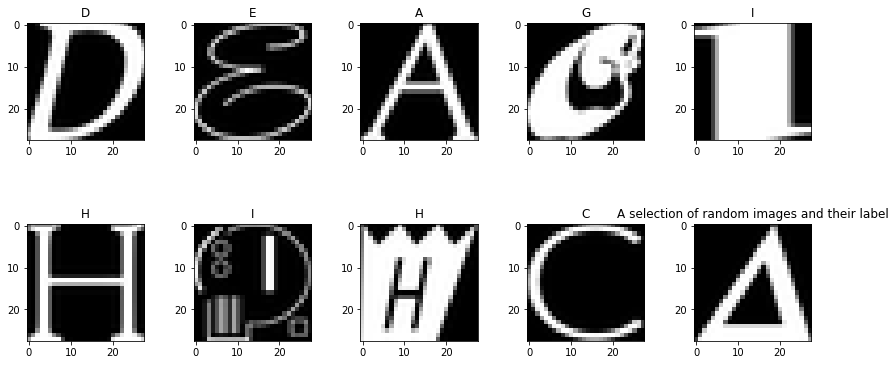

In [24]:
print("For the train dataset")
check_shuffle_effect(dataset=train_dataset,labels_list=train_labels)

For the valid dataset


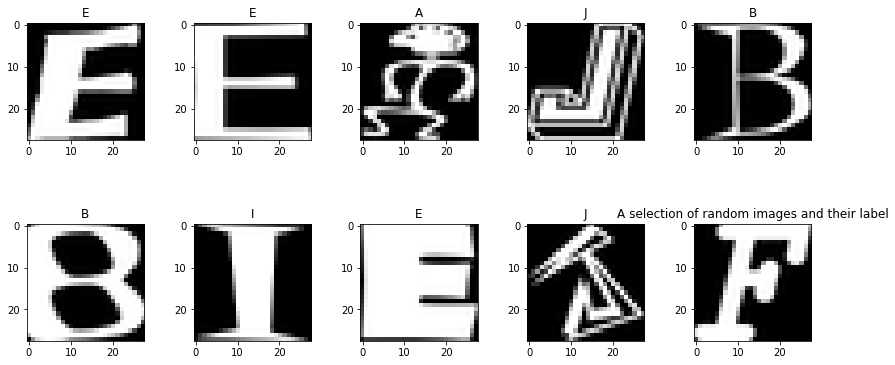

In [25]:
print("For the valid dataset")
check_shuffle_effect(dataset=valid_dataset,labels_list=valid_labels)

For the test dataset


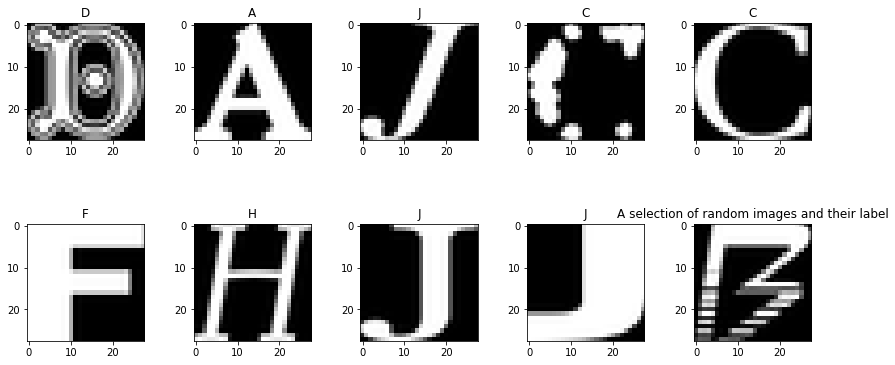

In [26]:
print("For the test dataset")
check_shuffle_effect(dataset=test_dataset,labels_list=test_labels)

In [27]:
# The images displayed and the label seems to be the right one. Some cases are a bit dodgy but that must be a proper to the way the dataset was generated.

Save the data for later reuse:



In [28]:

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    all_data_dict = {"train": {"data":train_dataset,"label":train_labels},
                    "val":{"data":valid_dataset,"label":valid_labels},
                    "test":{"data":test_dataset,"label":test_labels}
                    }
    
    with open(pickle_file, 'wb') as f:
        pkl.dump(all_data_dict, f, pkl.HIGHEST_PROTOCOL)

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [29]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800403


## Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set. Measure how much overlap there is between training, validation and test samples.

Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent questions.

In [ ]:
# I'm not running this cell because it's will clearly take to much time in its actual form. This function should be improve with the use of the map function maybe or some caching or even multiprocessing. But, I rather not waste time on that right now.
# I will come back to it if I have time some time left.

def sample_duplicate(dataset1,dataset2):
    """ Check the number of duplicate between 2 datasets """
    duplicate_index = []
    percent_done = 0
    # Comparing each image array from dataset1 to each image array in dataset2
    for i in range(dataset1.shape[0]):
        sample1 = dataset1[i,:,:]
        for j in range(dataset2.shape[0]):
            sample2 = dataset2[j,:,:]
            obvs = sample1 == sample2
            # Checking if all pixels are equal
            if np.sum(obvs) == dataset1.shape[1]*dataset1.shape[2]:
                duplicate_index.append(i)
        # Tracking the progress    
        percent_done = (i*100)/dataset1.shape[0]

        if percent_done % 5 == 0:
            sys.stdout.write("...%s%%" % percent_done)
            sys.stdout.flush()
    return duplicate_index

train_in_train_dup = sample_duplicate(train_dataset,train_dataset)
train_in_val_dup = sample_duplicate(train_dataset,valid_dataset)
train_in_test_dup = sample_duplicate(train_dataset,test_dataset)

# Should render something like
print(f"Duplicates inside training set:  {len(train_in_train_dup)}"
print(f"Duplicates between training and validation:  {len(train_in_val_dup)}"
print(f"Duplicates between training and test:  {len(train_in_test_dup)}"

In [30]:
# To check for near duplicate, I would need to add a tolerance level for the value of the sum. For example, we know that if its a duplicate, then the sum of the test between 2 images is 784 for 28 by 28 images. But for example, with a 5% level of tolerance
# a value of 758 or more would be suggesting that the images are duplicates. I would come back to it if I have time left.

## Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

In [33]:
from sklearn.linear_model import LogisticRegression
def get_sample_model(train_data,train_label,test_data,test_label,sample_size):
    # Getting the sample
    for size in sample_size:
        random_values = np.random.randint(low=0, high=train_data.shape[0], size=size)
        X_train = train_data[random_values,:,:]
        # Need to flatten the images because the LogisticRegression algorithm is expecting 2 dim array
        X_train_flatten = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
        y_train = train_label[random_values]
        X_test_flatten = test_data.reshape(test_data.shape[0],test_data.shape[1]*test_data.shape[2])
        # Model
        clf = LogisticRegression(random_state=0)
        clf.fit(X_train_flatten,y_train)
        train_score = clf.score(X_train_flatten,y_train)
        test_score = clf.score(X_test_flatten,test_label)
        
        print(f"*-*-*-*-* Train data size : {size} *-*-*-*-*")
        print('Training score = ', train_score)
        print('Test score = ', test_score)

In [34]:
get_sample_model(train_dataset,train_labels,test_dataset,test_labels,[50,100,1000,5000])

*-*-*-*-* Train data size : 50 *-*-*-*-*
Training score =  1.0
Test score =  0.6546
*-*-*-*-* Train data size : 100 *-*-*-*-*
Training score =  1.0
Test score =  0.7575


C:\Users\geoff\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\geoff\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

*-*-*-*-* Train data size : 1000 *-*-*-*-*
Training score =  1.0
Test score =  0.8412
*-*-*-*-* Train data size : 5000 *-*-*-*-*
Training score =  0.972
Test score =  0.8374


C:\Users\geoff\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# We can clearly see that with more data, the model is giving better result on the test data. The Training score of 1 should not really be taken in account because with such small sample the model is going to overfit. Nevertheless, clearly here, there is something to learn
# with more data, more tuning or a better model.

## Problem 7
Going on step deeper. 
Please propose a model of your choice.
If you run out of time, you do not have to implement the full code, but explain the steps you need to implement and every parameter choice you make.

We first need to reformat the data

Reformat into a shape that's more adapted to the models we're going to train:

 - data as a flat matrix,
 - labels as float 1-hot encodings.

In [35]:
# I'm going for a neural network here because it's known to have good result with the Minst dataset and this one look a lot like it. Also it should be fast and easy to tune for this dataset
# Here, we are expanding the dimension of the datasets to adapt to the format expected by Tensorflow : batch_shape + (rows, cols, channels) with data_format='channels_last' in the convolutional Layer

train_nn = np.expand_dims(train_dataset,axis = -1)
val_nn = np.expand_dims(valid_dataset,axis = -1)
test_nn = np.expand_dims(test_dataset,axis = -1)

# Label hot encoding 
y_train = tf.one_hot(train_labels,depth=len(label_dict))
y_val = tf.one_hot(valid_labels,depth=len(label_dict))
y_test = tf.one_hot(test_labels,depth=len(label_dict))


You can choose a simple multinomial logistic regression using simple gradient descent, or any other multi layer version. Just don't  overengineer and make sure that this model improves your validation / test accuracy from previous problems.

In [36]:
# Let's build our model

model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4),input_shape=(28, 28, 1), activation='relu',data_format='channels_last'))
# Pooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Flattening the images to be able to input them in a dense layer
model.add(tf.keras.layers.Flatten())

# A Dense layer with 128 neurons (Hidden layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))

# The dense layer that those the classification with 10 neurons as we got 10 classes
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# I'm using the categorical_crossentropy loss function because we are dealing with a multiclassification issue and this function will punish the model more when it is confident when it is wrong. We should then have more robust results.
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [37]:
# A summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(train_nn,y_train,epochs=10,validation_data=(val_nn,y_val),batch_size=32)

Epoch 1/10
6250/6250 [==============================] - 66s 10ms/step - loss: 0.4165 - accuracy: 0.8778 - val_loss: 0.3525 - val_accuracy: 0.8945
Epoch 2/10
6250/6250 [==============================] - 65s 10ms/step - loss: 0.3294 - accuracy: 0.9038 - val_loss: 0.3488 - val_accuracy: 0.8959
Epoch 3/10
6250/6250 [==============================] - 64s 10ms/step - loss: 0.3092 - accuracy: 0.9094 - val_loss: 0.3474 - val_accuracy: 0.8955
Epoch 4/10
6250/6250 [==============================] - 63s 10ms/step - loss: 0.3013 - accuracy: 0.9122 - val_loss: 0.3517 - val_accuracy: 0.8942
Epoch 5/10
6250/6250 [==============================] - 63s 10ms/step - loss: 0.2954 - accuracy: 0.9143 - val_loss: 0.3589 - val_accuracy: 0.9037
Epoch 6/10
6250/6250 [==============================] - 65s 10ms/step - loss: 0.2910 - accuracy: 0.9154 - val_loss: 0.3637 - val_accuracy: 0.9004
Epoch 7/10
6250/6250 [==============================] - 64s 10ms/step - loss: 0.2901 - accuracy: 0.9166 - val_loss: 0.3680 -

In [39]:
losses = model.history.history

Text(0.5, 1.0, 'Train loss Vs Val loss')

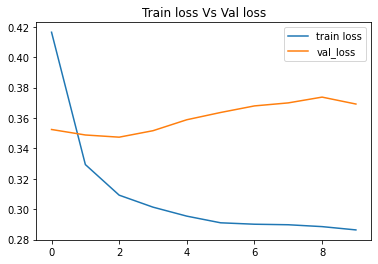

In [40]:
plt.plot(losses["loss"],label = "train loss")
plt.plot(losses["val_loss"], label = "val_loss")
plt.legend()
plt.title("Train loss Vs Val loss")

Text(0.5, 1.0, 'Train accuray Vs Val accuracy')

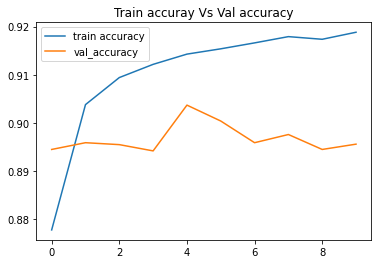

In [41]:
plt.plot(losses["accuracy"],label="train accuracy")
plt.plot(losses["val_accuracy"],label="val_accuracy")
plt.legend()
plt.title("Train accuray Vs Val accuracy")

In [ ]:
# It seems like 1 epoch is enough for this model. Indeed after 1 epoch, the model is overfitting.
# THis might just be that it's very easy for the neural network the find the discriminative pattern amoung the images to classify them. It can't be an issue where some classes are being very well classified and other not beacause the data is perfectly balance accross all classes
# We could see that if we could use the classification report of sklearn but it's not one of the module allowed.
# Nevertheless, our model seems to be doing quiete well. We could tune things a bit by adding maybe another convolutional layer, or more units by layer but that seems like an overkill. What would be interesting here would actually be some dropout layer to reducing the overfitting.
# The fine tuning of hyperparameter like the number of units, layers, batch size, dropout probability and others could be easily be done with Gridsearch by transforming our model into a sklearn classifier tanks to KerasClassifier wrapper for sklearn but we do not have time for that and those module are
# not allowed in this test.

In [42]:
# Evaluating the model on the test set
model.evaluate(test_nn,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1962 - accuracy: 0.9408


[0.1962069272994995, 0.9408000111579895]

In [ ]:
# The model with overfitting is doing quiet well on the test dataset with an accuracy score of 94.08% and a very low log loss

In [43]:
# Reruning the model with 1 epoch

In [44]:
model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4),input_shape=(28, 28, 1), activation='relu',data_format='channels_last'))
# Pooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Flattening the images to be able to input them in a dense layer
model.add(tf.keras.layers.Flatten())

# A Dense layer with 128 neurons (Hidden layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))

# The dense layer that those the classification with 10 neurons as we got 10 classes
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# I'm using the categorical_crossentropy loss function because we are dealing with a multiclassification issue and this function will punish the model more when it is confident when it is wrong. We should then have more robust results.
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [45]:
model.fit(train_nn,y_train,epochs=1,validation_data=(val_nn,y_val),batch_size=32)

6250/6250 [==============================] - 64s 10ms/step - loss: 0.4113 - accuracy: 0.8797 - val_loss: 0.3451 - val_accuracy: 0.8959


In [46]:
model.evaluate(test_nn,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1762 - accuracy: 0.9502


[0.17618057131767273, 0.9502000212669373]

In [47]:
# The results are better here with one epoch but  as we can see in training, there is some underfitting going on. Therefore, there is much to learn and that can be solve by more Conv layer, or units by layer for exemple.